# Importing Required Libraries


In [31]:
import numpy as np
import pandas as pd
import nltk
import gensim.downloader as api
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer


# Loading the dataset


In [32]:
train = pd.read_csv("./Data/train.csv")
test = pd.read_csv("./Data/test.csv")

# EDA


In [33]:
columns = train.columns
columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

In [34]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [35]:
train.describe(include="object")

,keyword,location,text
count,7552,5080,7613
unique,221,3341,7503
top,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...
freq,45,104,10


In [36]:
train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


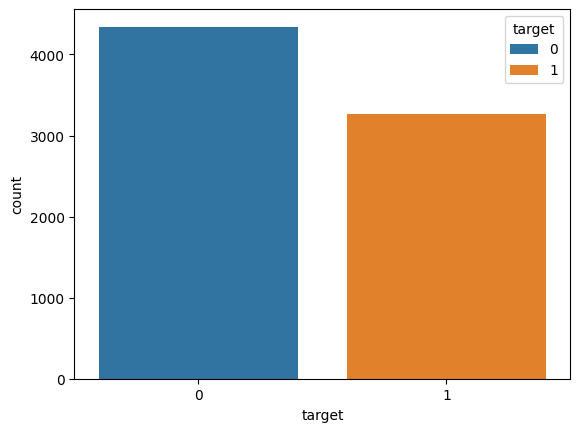

In [37]:
sns.countplot(train, x="target", hue="target");

# Data Preprocessing


## Drop duplicates text and Drop text with conflict target


In [38]:
train[train.text.duplicated()].groupby("text").apply(lambda x: x).drop(
    "text", axis=1
).head()

id         keyword  \
text                                                                            
#Allah describes piling up #wealth thinking it ... 4299  6105        hellfire   
                                                   4312  6123        hellfire   
#Bestnaijamade: 16yr old PKK suicide bomber who... 6366  9098  suicide%20bomb   
                                                   6373  9107  suicide%20bomb   
                                                   6377  9113  suicide%20bomb   

                                                                           location  \
text                                                                                  
#Allah describes piling up #wealth thinking it ... 4299  ?????? ??? ?????? ????????   
                                                   4312          ?????? ???? ??????   
#Bestnaijamade: 16yr old PKK suicide bomber who... 6366                     Nigeria   
                                                   6373                     Nigeria   
                                                   6377                     Nigeria   

                                                         target  
text                                                             
#Allah describes piling up #wealth thinking it ... 4299       0  
                                                   4312       1  
#Bestnaijamade: 16yr old PKK suicide bomber who... 6366       1  
                                                   6373       1  
                                                   6377       1

In [39]:
print(f"{train.text.duplicated().sum()/len(train)*100:0.2f}%")

1.44%


In [40]:
# Store duplicated text
duplicated = train.text.duplicated()

# convert dtype of target to float (to store 0.5 which indicates text with conflict target)
train.target = train.target.astype(np.float16)

# compute median target for each group
median_target = train.groupby("text").target.transform("median")

# update target by median_target
train.loc[:, "target"] = median_target

# drop duplicated text with conflict target (median_target = 0.5)
train = train[median_target != 0.5]

# drop duplicated text and keep one
train.drop_duplicates(subset="text", keep="first", inplace=True)

# return the dtype of target to int
train.target = train.target.astype(np.int8)

In [41]:
train[duplicated].groupby("text").apply(lambda x: x).drop("text", axis=1)

C:\Users\mmria\AppData\Local\Temp\ipykernel_19340\1298107107.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train[duplicated].groupby("text").apply(lambda x: x).drop("text", axis=1)


,id,keyword,location,target
text,,,,


## Clean the tweet text
by removing noise such as special characters, URLs, and HTML tags.

In [42]:
def clean_text(sent: str) -> str:
    # sub url
    sent = re.sub("http.*? ", "", sent)
    # sub html tags
    sent = re.sub("<.*?>", "", sent)
    # sub special characters
    sent = re.sub("[^a-zA-Z]", " ", sent)
    return sent


train.text = train.text.apply(clean_text)
test.text = test.text.apply(clean_text)

## Normalize the text
by converting to lowercase, removing stopwords, and applying stemming or lemmatization.

In [13]:
# another way to remove stopwords using numpy
stop = ["i", "am"]
sent = "I am from Jordan"
sent = sent.lower()
sent = np.array(nltk.tokenize.word_tokenize(sent))
not_in_stop = ~np.isin(sent, stop)
sent = sent[not_in_stop]
sent = " ".join(sent)
print(sent)

from jordan


In [43]:
# POS
# -----------------------
# n: noun
# v: verb
# a: adjective
# r: adverb
# s: satellite adjectives


def get_wordnet_pos(treebank_tag: str) -> str:
    if treebank_tag.startswith("J"):
        return "a"
    elif treebank_tag.startswith("V"):
        return "v"
    elif treebank_tag.startswith("N"):
        return "n"
    elif treebank_tag.startswith("R"):
        return "r"
    else:
        return ""


def lemma(sent: str) -> str:
    wnl = nltk.stem.WordNetLemmatizer()
    sent = nltk.pos_tag(sent)
    sent = [(w, get_wordnet_pos(p)) for w, p in sent]
    sent = [wnl.lemmatize(w, p) if p != "" else w for w, p in sent]

    return sent

In [44]:
english_stopwords = nltk.corpus.stopwords.words("english")
english_stopwords.remove("not")


def normalize_text(sent: str) -> str:
    # convert to lowercase
    sent = sent.lower()
    # removing stopwords
    sent = [
        word
        for word in nltk.tokenize.word_tokenize(sent)
        if word not in english_stopwords
    ]
    # applying lemmatization
    sent = lemma(sent)
    sent = " ".join(sent)
    return sent


train.text = train.text.apply(normalize_text)
test.text = test.text.apply(normalize_text)

## Tokenize the text 
to convert sentences into individual words or tokens for further analysis.

In [45]:
# word tokenize
train.text = train.text.apply(nltk.tokenize.word_tokenize)
test.text = test.text.apply(nltk.tokenize.word_tokenize)

In [46]:
train.text

0       [deed, reason, earthquake, may, allah, forgive...
1           [forest, fire, near, la, ronge, sask, canada]
2       [resident, ask, shelter, place, notify, office...
3       [people, receive, wildfire, evacuation, order,...
4       [get, sent, photo, ruby, alaska, smoke, wildfi...
                              ...                        
7604    [worldnews, fall, powerlines, g, link, tram, u...
7605    [flip, side, walmart, bomb, everyone, evacuate...
7606    [suicide, bomber, kill, saudi, security, site,...
7608    [two, giant, crane, hold, bridge, collapse, ne...
7612    [late, home, raze, northern, california, wildf...
Name: text, Length: 7493, dtype: object

In [47]:
test.text

0                          [happen, terrible, car, crash]
1       [heard, earthquake, different, city, stay, saf...
2       [forest, fire, spot, pond, geese, flee, across...
3                  [apocalypse, light, spokane, wildfire]
4                [typhoon, soudelor, kill, china, taiwan]
                              ...                        
3258    [earthquake, safety, los, angeles, safety, fas...
3259    [storm, ri, bad, last, hurricane, city, amp, o...
3260    [green, line, derailment, chicago, http, co, u...
3261    [meg, issue, hazardous, weather, outlook, hwo,...
3262    [cityofcalgary, activate, municipal, emergency...
Name: text, Length: 3263, dtype: object

# Feature Extraction

## Employ TF-IDF or word embeddings 
to convert text data into a numerical format that can be processed by machine learning models.
 

In [48]:
# define X and y for train and test sets.
X_train = train.text
y_train = train.target

X_test = test.text

In [54]:
# Word embeddings
model = api.load("word2vec-google-news-300")

In [84]:
def get_word2vec_embedding(text, model):
    words = list(text)
    embeddings = [model[word] for word in words if word in model]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(model.vector_size)

In [87]:
X_train_embedding = np.array([get_word2vec_embedding(tweet, model) for tweet in X_train])

X_test_embedding = np.array([get_word2vec_embedding(tweet, model) for tweet in X_test])

## Consider extracting additional features 
from the tweets, like tweet length or specific keywords.


In [92]:
# tweet length
train_length = X_train.apply(len)
test_length = X_test.apply(len)
# specific keywords

# Model Training and Selection:
Divide the dataset into training and testing sets for model evaluation.
Train different machine learning models like Naive Bayes, Logistic Regression, Support Vector Machines, and neural networks.
Use cross-validation to optimize model parameters and prevent overfitting.****

In [94]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()

In [101]:
from scipy.sparse import hstack

In [110]:
clf.fit(X_train_embedding, y_train)

RandomForestClassifier()

# Model Evaluation:
Use metrics like accuracy, precision, recall, and F1-score to evaluate the model's performance in classifying tweets.
Review the confusion matrix for each model to identify classification errors.

In [111]:
from sklearn.metrics import classification_report

In [113]:
print(classification_report(y_train, clf.predict(X_train_embedding)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4302
           1       1.00      0.98      0.99      3191

    accuracy                           0.99      7493
   macro avg       0.99      0.99      0.99      7493
weighted avg       0.99      0.99      0.99      7493



In [130]:
result = pd.DataFrame({"id":test.id, "target":clf.predict(X_test_embedding)})

In [131]:
result.to_csv("result.csv", index=False)

The model got 0.78 on the public leaderboard.
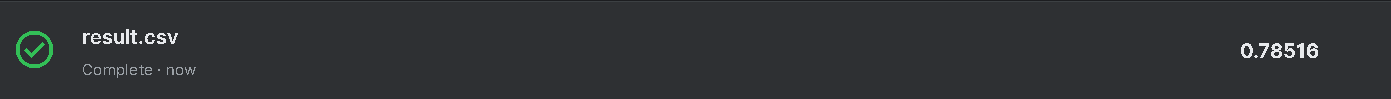
